<a href="https://colab.research.google.com/github/QUAY17/SWE-326/blob/main/RobinStocksScratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Robin' Stocks](https://robin-stocks.readthedocs.io/en/latest/index.html) to interface with RH API ([AlgoTrading101 guide](https://algotrading101.com/learn/robinhood-api-guide/))

## Install:

In [ ]:
# installing it to the colab machine and importing libraries
!pip install robin_stocks
import robin_stocks
import robin_stocks.robinhood as r

     |████████████████████████████████| 131 kB 5.0 MB/s 
     |████████████████████████████████| 3.6 MB 50.6 MB/s 


## Login to RH (use for GUI login)

In [ ]:
# Must login to use most of the features from the RH API
login = r.login("JQuayVo","hgPSznGL5STp8QK")

## Experimenting with some random RS commands...

In [ ]:
# Playing around with some commands available:
robin_stocks.robinhood.stocks.get_quotes('TSLA') # get latest bid/ask price on the order book
#robin_stocks.robinhood.stocks.find_instrument_data('TSLA') # RH info on TSLA ticker and company basics


401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA


[None]

## Get historical data from RH (top panel of our GUI)


There looks to be select pairs that work:

*   interval='hour', span='day'
*   interval='day', span='year'
*   ...



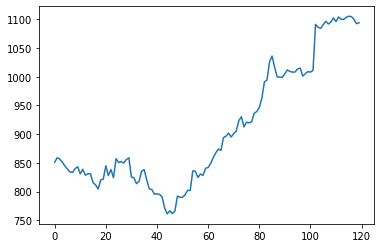

In [ ]:
# get historical data, default is hourly for the past week
data = robin_stocks.robinhood.stocks.get_stock_historicals('TSLA', interval='hour', span='month')

# making a little plot of historical data
import matplotlib.pyplot as plt

prices = []
times = []
for datum in data:
    prices.append(float(datum['close_price']))
    times.append(datum['begins_at']) # needs better formatting

plt.plot(range(len(prices)), prices)
plt.show()

## Get market price every X seconds (passed output to algo for a decision):


In [ ]:
from time import sleep
while True:
    price = r.get_latest_price('TSLA')
    print(price)
    sleep(60)

401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhood.com/quotes/?symbols=TSLA
[None]
401 Client Error: Unauthorized for url: https://api.robinhoo

# [Backtrader](https://www.backtrader.com/) and the [AlgoTrading101 guide](https://algotrading101.com/learn/backtrader-for-backtesting/)



In [ ]:
# installing backtrader and the yahoo finance data feed
!pip install backtrader 
!pip install yfinance
import backtrader as bt
import yfinance as yf
from datetime import datetime
import matplotlib as plt

     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# example of getting historical data on a ticker from yahoo
def get_history(ticker):
    return yf.Ticker(ticker).history(period='max')
    
get_history('TSLA')

## Strategies that can be loaded into the engine:

In [ ]:
class SMA50Strategy(bt.SignalStrategy):

    def __init__(self):  # Initiation
        self.sma = bt.ind.SimpleMovingAverage(period=50)  # Processing
    
    def next(self):  # Processing
        if self.sma > self.data.close:
            self.buy()

        elif self.sma < self.data.close: # Post-processing
            self.close()


In [ ]:
# simple-moving-average
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma = bt.ind.SMA(period=50)
        price = self.data
        crossover = bt.ind.CrossOver(price, sma)
        self.signal_add(bt.SIGNAL_LONG, crossover)

In [ ]:
# whatever the Donchian is ...
class DonchianChannels(bt.Indicator):
    '''
    Params Note:
      - `lookback` (default: -1)
        If `-1`, the bars to consider will start 1 bar in the past and the
        current high/low may break through the channel.
        If `0`, the current prices will be considered for the Donchian
        Channel. This means that the price will **NEVER** break through the
        upper/lower channel bands.
    '''

    alias = ('DCH', 'DonchianChannel',)

    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )

    def __init__(self):
        hi, lo = self.data.high, self.data.low
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)

        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above



In [ ]:
# make your own!
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.myind = DonchianChannels()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()

## Running the Cerebro Engine (backtesting):

In [ ]:
class SMA50Strategy(bt.SignalStrategy):
    def __init__(self):  # Initiation
        self.sma = bt.ind.SimpleMovingAverage(period=50)  # Processing
    
    def next(self):  # Processing
        if self.sma > self.data.close:
            self.buy()
        elif self.sma < self.data.close: # Post-processing
            self.close()

# needed for plot
%matplotlib inline

def backtest(strategy, ticker, fromdate, todate, cash=1000, commission=0.00):
    '''using backtest to create a general backtester'''

    # initialize the engine with your strategy, cash amount, etc
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # pulling the data to put into the engine
    data = bt.feeds.PandasData(dataname=yf.download(ticker, fromdate, todate))
    cerebro.adddata(data)


    # run the backtest!
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # plot it, the extra plt commands for getting it inline, default doesn't work in colab
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams.update({'font.size': 12}) 
    cerebro.plot(iplot=False)
  
if __name__ == '__main__':

    # backtest
    backtest(strategy=SMA50Strategy, ticker='TSLA', fromdate='2018-01-01', todate='2022-04-01')

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 1000.00
Ending Portfolio Value: 1701.33


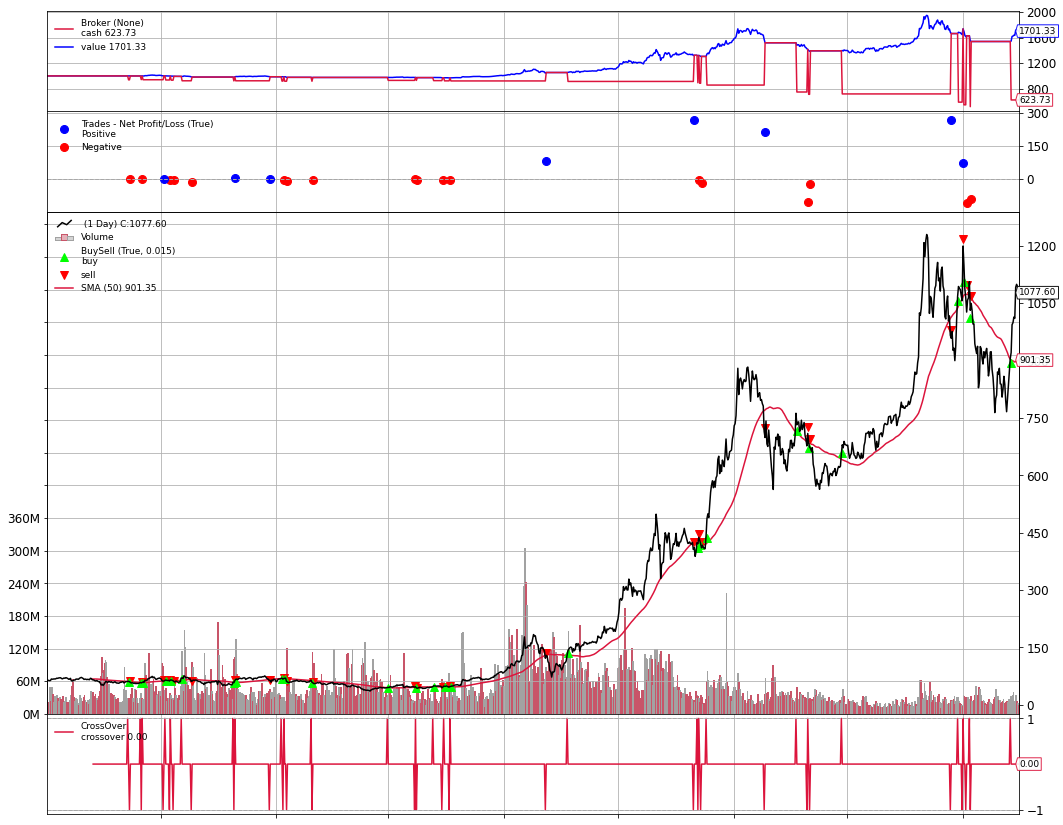

In [ ]:
# and now tesla with a different strategy!
# simple-moving-average
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        self.sma = bt.ind.SMA(period=50)
        price = self.data
        crossover = bt.ind.CrossOver(price, self.sma)
        self.signal_add(bt.SIGNAL_LONG, crossover)
    """  
    def next(self):  # Processing
        if self.sma > self.data.close:
            self.buy()
        elif self.sma < self.data.close: # Post-processing
            self.close()"""

# needed for plot
%matplotlib inline

def backtest(strategy, ticker, fromdate, todate, cash=1000, commission=0.00):
    '''using backtest to create a general backtester'''

    # initialize the engine with your strategy, cash amount, etc
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # pulling the data to put into the engine
    data = bt.feeds.PandasData(dataname=yf.download(ticker, fromdate, todate))
    cerebro.adddata(data)
  

    # run the backtest!
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # plot it, the extra plt commands for getting it inline, default doesn't work in colab
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams.update({'font.size': 12}) 
    cerebro.plot(iplot=False)
  
if __name__ == '__main__':

    # backtest
    backtest(strategy=SmaCross, ticker='TSLA', fromdate='2018-01-01', todate='2022-04-01')

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 1000.00
Ending Portfolio Value: 1933.38


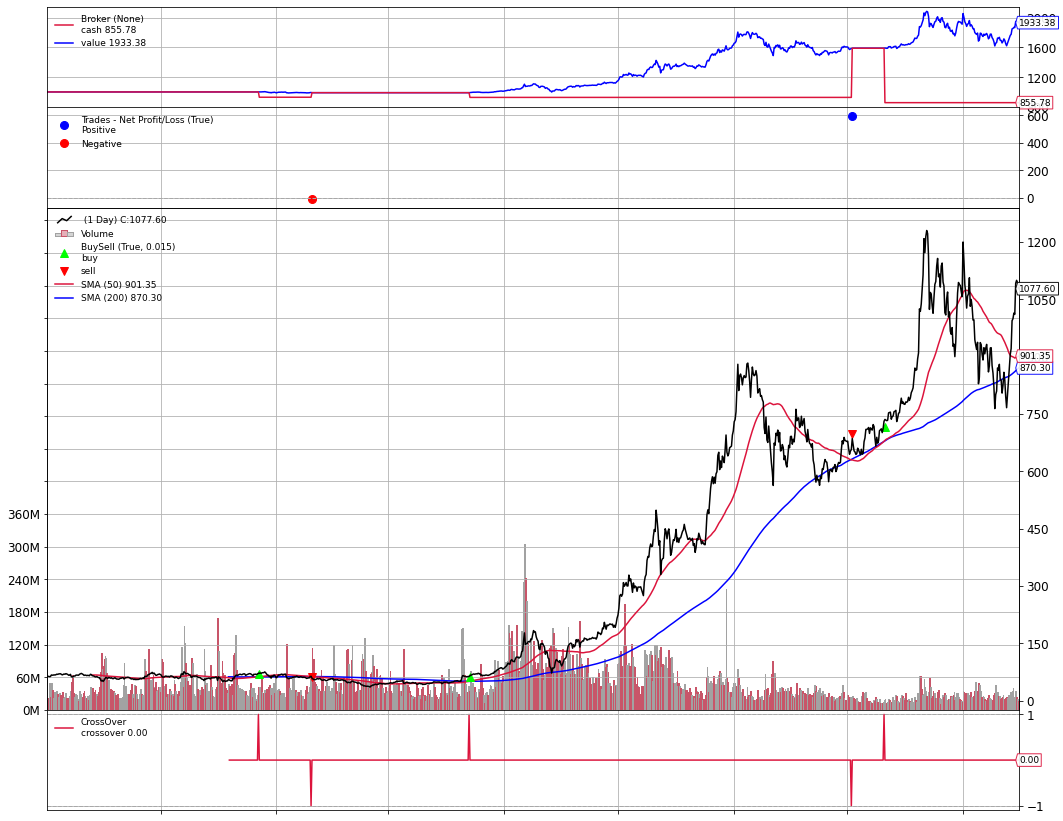

In [ ]:
"""
* creates Dual Moving Average (DMA) Strategy
* SIGNAL_LONG is trading logic
"""        
class DMAStrategy(bt.SignalStrategy):
    def __init__(self):
        short, long = bt.ind.SMA(period=50), bt.ind.SMA(period=200)
        crossover = bt.ind.CrossOver(short, long)
        self.signal_add(bt.SIGNAL_LONG, crossover) #this is the trading logic
"""
* backtest function
* uses strategy selection from user
* ticker input from user
* cash input by user
* commission set to 0
"""
def backtest(strategy, ticker, fromdate, todate, cash, commission=0.00):

    # initialize the engine with your strategy, cash amount, etc
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # pulling the data to put into the engine
    data = bt.feeds.PandasData(dataname=yf.download(ticker, fromdate, todate))
    cerebro.adddata(data)
    print(data)

    # show portfolio stats before and after runnign the backtest
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # plot it
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams.update({'font.size': 12}) 
    cerebro.plot(iplot=False)


if __name__ == '__main__':

    # backtest
    backtest(strategy=DMAStrategy, ticker='TSLA', fromdate='2018-01-01', todate='2022-04-01', cash=1000.0)


In [ ]:
import yfinance as yf
stock_list = ['0005.HK', '0006.HK', '0066.HK', '0700.HK', '2800.HK']
print('stock_list:', stock_list)
data = yf.download(stock_list, start="2015-01-01", end="2020-02-21")
print('data fields downloaded:', set(data.columns.get_level_values(0)))
data.head()

stock_list: ['0005.HK', '0006.HK', '0066.HK', '0700.HK', '2800.HK']
[*********************100%***********************]  5 of 5 completed
data fields downloaded: {'Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume'}


Adj Close                                                   Close  \
              0005.HK    0006.HK    0066.HK     0700.HK    2800.HK    0005.HK   
Date                                                                            
2015-01-02  52.065151  41.947819  23.567179  110.794685  24.049999  74.000000   
2015-01-05  51.291199  41.244473  23.493307  111.482224  23.950001  72.900002   
2015-01-06  50.482082  41.103794  23.271667  117.866684  23.650000  71.750000   
2015-01-07  49.954399  41.722748  23.419424  122.188454  23.900000  71.000000   
2015-01-08  50.095112  42.454224  23.825754  125.036903  24.100000  71.199997   

                                                         ...       Open  \
              0006.HK    0066.HK     0700.HK    2800.HK  ...    0005.HK   
Date                                                     ...              
2015-01-02  74.550003  31.900000  112.800003  24.049999  ...  73.599998   
2015-01-05  73.300003  31.799999  113.500000  23.950001  ...  73.150002   
2015-01-06  73.050003  31.500000  120.000000  23.650000  ...  71.800003   
2015-01-07  74.150002  31.700001  124.400002  23.900000  ...  70.500000   
2015-01-08  75.449997  32.250000  127.300003  24.100000  ...  71.050003   

                                                           Volume           \
              0006.HK    0066.HK     0700.HK    2800.HK   0005.HK  0006.HK   
Date                                                                         
2015-01-02  74.849998  31.799999  113.599998  23.900000   8614012   998065   
2015-01-05  73.250000  31.650000  113.500000  23.950001  21629040  1925637   
2015-01-06  74.150002  31.450001  114.000000  23.700001  35110417  3477505   
2015-01-07  72.699997  31.250000  123.500000  23.600000  35378291  2477304   
2015-01-08  75.099998  31.950001  127.500000  23.900000  21320949  3044459   

                                         
            0066.HK   0700.HK   2800.HK  
Date                                     
2015-01-02  1231870  10862542  21618598  
2015-01-05  2120890  21808993  71563266  
2015-01-06  3531739  43678255  78830872  
2015-01-07  3066795  40863410  63966468  
2015-01-08  7878824  35638986  39175442  

[5 rows x 30 columns]

## Recreating the example of Apple!

In [ ]:
backtest(strategy=SmaCross, ticker='AAPL', fromdate='2017-01-01', todate='2017-12-31')

NameError: ignored

# [Yahoo Finance for Fundamental Analysis](https://algotrading101.com/learn/yfinance-guide/)

In [ ]:
!pip install yfinance
import yfinance as yf


In [ ]:
# example loading tesla and its FA
tsla = yf.Ticker("tsla")
#tsla.info.keys()

# these are only some keys, not all
keys = ['industry', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'grossProfits', 'freeCashflow', 'earningsGrowth', 'currentRatio', 'totalRevenue', 'forwardEps', 'beta', 'earningsQuarterlyGrowth', 'forwardPE']
for key in keys:
    print('%s: %s' % (key, str(tsla.info[key])))

industry: Auto Manufacturers
profitMargins: 0.102539994
grossMargins: 0.25279
operatingCashflow: 11496999936
revenueGrowth: 0.649
operatingMargins: 0.121190004
grossProfits: 13606000000
freeCashflow: 4628125184
earningsGrowth: 7.538
currentRatio: 1.375
totalRevenue: 53823000576
forwardEps: 13.35
beta: 2.04872
earningsQuarterlyGrowth: 7.596
forwardPE: 85.80149


In [ ]:
tsla = yf.Ticker("tsla")
percent_keys = ['profitMargins', 'grossMargins', 'revenueGrowth', 'operatingMargins']
for key in percent_keys:
    print("%s: %s%%" % (key, str(round(100 * tsla.info[key], 1))))


profitMargins: 10.3%
grossMargins: 25.3%
revenueGrowth: 64.9%
operatingMargins: 12.1%


In [ ]:
tsla = yf.Ticker('tsla')
forward_keys = ['forwardEps', 'forwardPE']
for key in forward_keys:
    print('%s: %s' % (key, round(tsla.info[key], 2)))


forwardEps: 13.35
forwardPE: 85.8


## Ticker data from yahoo finance (example)
Get ticker data from yahoo finance
* acceses yahoo finance api
* ticker data  
* fundamentals 
* historical market data


In [ ]:
def ticker_data():

    msft = yf.Ticker("MSFT") #select ticker
    print(msft.info) # get fundamental data
    print(msft.history(period="max")) # get historical data

# Federal Reserve Economic Data (Nasdaq Data Link / Quandl need API keys)

In [ ]:
!pip install fredapi

In [ ]:
import fredapi as fa

In [ ]:
fred = fa.Fred(api_key='')

In [ ]:
gdp = fred.get_series('GDP')

ValueError: ignored

# Federal Reserve Economic Data (FRED)
 * [API Github](https://github.com/letsgoexploring/fredpy)

In [1]:
!pip install fredpy

In [4]:
# you need to make an account to get an API key
import fredpy as fp
import matplotlib.pyplot as plt

In [3]:
fp.api_key = '59b76a3e8c24982778e2ae0c69a92996'

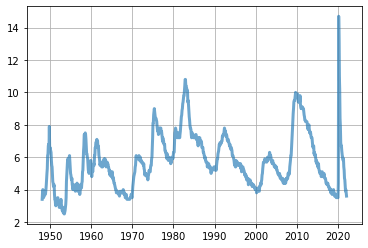

In [9]:
unemployment = fp.series('UNRATE')
plt.plot(unemployment.data.index, unemployment.data.values,'-',lw=3,alpha = 0.65)
plt.grid()

In [20]:
# single datapoint example
print("Unemployment Rate: %s%%" % unemployment.data[-1])

Unemployment Rate: 3.6%


In [40]:
# Download quarterly real GDP data - used for US total output
gdp = fp.series('gdpc1')
print("Quarterly GDP (billions): ", gdp.data[-1])

Quarterly GDP (billions):  19806.29


In [41]:
# consumer price index
cpi = fp.series('CPIAUCSL')
#print(cpi.data[-6:])
diff = ((cpi.data[-1] / cpi.data[-2]) - 1) * 100 
print("CPI change since last month: %s%%" % round(diff, 2))

CPI change since last month: 0.8%


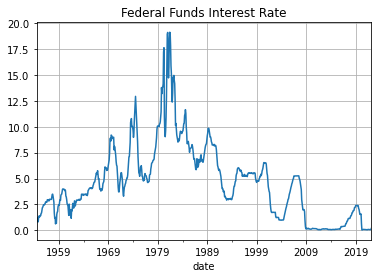

In [48]:
# Custom API Queries
import datetime
import pandas as pd
import numpy as np 


# Specify the API path
path = 'fred/series/observations'

# Set observation_date string as today's date
observation_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Specify desired parameter values for the API querry; knowing series_id is key!
parameters = {'series_id':'FEDFUNDS',
  'observation_date':observation_date,
  'file_type':'json'
 }

# API request
r = fp.fred_api_request(api_key=fp.api_key,path=path,parameters=parameters)

# Return results in JSON format
results = r.json()

# Load data, deal with missing values, format dates in index, and set dtype
data = pd.DataFrame(results['observations'],columns =['date','value'])
data = data.replace('.', np.nan)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')['value'].astype(float)

# Plot the unemployment rate
data.plot()
plt.title("Federal Funds Effective Overnight Rate")
plt.grid()

In [55]:
print("Fed Overnight rate: %s%%" % data[-1])

Fed Overnight rate: 0.2%


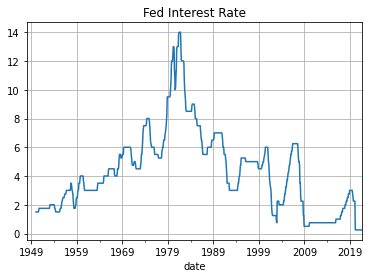

In [56]:
# Specify the API path
path = 'fred/series/observations'

# Set observation_date string as today's date
observation_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Specify desired parameter values for the API querry; knowing series_id is key!
parameters = {'series_id':'INTDSRUSM193N',
  'observation_date':observation_date,
  'file_type':'json'
 }

# API request
r = fp.fred_api_request(api_key=fp.api_key,path=path,parameters=parameters)

# Return results in JSON format
results = r.json()

# Load data, deal with missing values, format dates in index, and set dtype
data = pd.DataFrame(results['observations'],columns =['date','value'])
data = data.replace('.', np.nan)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')['value'].astype(float)

# Plot the unemployment rate
data.plot()
plt.title("Fed Interest Rate")
plt.grid()

In [58]:
print("Fed Interest Rate: %s%%" % data[-1])

Fed Interest Rate: 0.25%
